In [31]:
# start step-by step
from skimage import io, feature, filters
import skimage
from skimage.morphology import disk 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

In [33]:
# some constants 
sigmas=[1, 3]

In [47]:
# function generates the features and returns them
# image - initial image
# sigma - initial and final sigmas for difference-of-gaussians and other filters 
def generate_features(image, sigma):
    # generate range of sigmas
    sigmas = range(sigma[0], sigma[1] + 1)
    
    f_sobel = filters.sobel(image).flatten()
    f_gauss = np.zeros([len(image.flatten()), len(sigmas)])
    f_dog = np.zeros([len(image.flatten()), len(sigmas) - 1])
    f_gabor = np.zeros([len(image.flatten()), len(sigmas)])
    
    idx = 0
    for s in range(sigma[0], sigma[1] + 1):
        # consider only Re part for gabor filter
        f_gabor[:, idx] = filters.gabor(image, s)[0].flatten()
        f_gauss[:, idx] = filters.gaussian(image, s).flatten()
        if (idx != 0):
            f_dog[:, idx - 1] = f_gauss[:, idx] - f_gauss[:, idx - 1]
        idx += 1
    
    # f_median = filters.median(image, disk(sigma))
    f_hessian = filters.hessian(image).flatten()
    f_laplacian = filters.laplace(image).flatten()
    # full set of features
    f_set = np.vstack([f_sobel, f_gauss.T, 
                       f_dog.T, f_hessian, 
                       f_laplacian, f_gabor.T]).T
    return f_set

In [48]:
# read the raw data and the binary classification (test data)
raw = io.imread('data/raw-49.tif')
cells = io.imread('data/binary-49.tif')
bg = np.invert(cells)

raw data size: (555, 380)
cells data size: (555, 380)


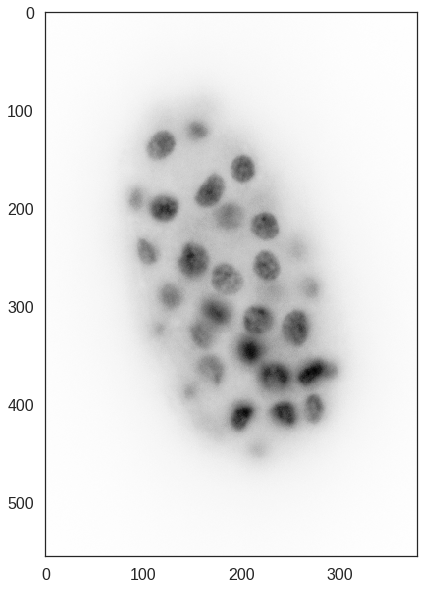

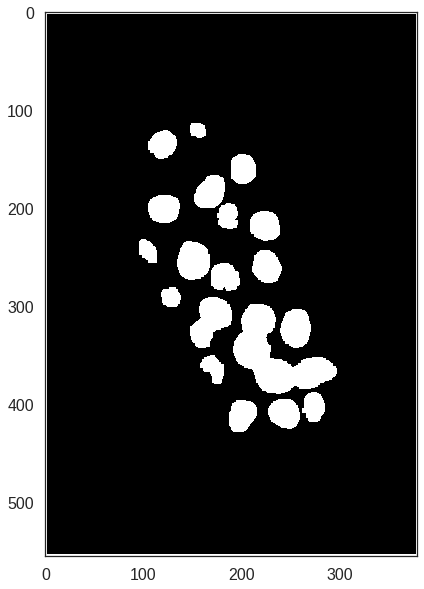

In [49]:
# some feedback
print("raw data size:" , raw.shape)
plt.figure(figsize=(20,10))
plt.imshow(raw)

print("cells data size:", cells.shape)
plt.figure(figsize=(20,10))
plt.imshow(cells)

# print(bg.shape)
# plt.figure(figsize=(20,10))
# plt.imshow(bg)

In [50]:
# check which values correspond to cells
cells[cells == 255] = 1
np.unique(cells)

array([0, 1], dtype=uint8)

In [51]:
y = cells.flatten()
X = generate_features(raw, sigmas)
print("# of generated features: ", X.shape[1])


# of generated features:  10


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X.shape, X_train.shape, X_test.shape

((210900, 10), (141303, 10), (69597, 10))

In [53]:
%%time
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

CPU times: user 3.98 s, sys: 4 ms, total: 3.98 s
Wall time: 3.98 s


In [54]:
y_hat = clf.predict(X_test)
print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

          0       0.97      0.89      0.93      6688
          1       0.99      1.00      0.99     62909

avg / total       0.99      0.99      0.99     69597



In [55]:
skf = StratifiedKFold(y, 5)
precision_scores = list()
recall_scores = list()
aucs = list()
for train_ix, test_ix in skf: # for each of K folds
    # define training and test sets
    X_train, X_test = X[train_ix,:], X[test_ix,:]
    y_train, y_test = y[train_ix], y[test_ix]
    
    # Train classifier
    clf = RandomForestClassifier(n_jobs=2)
    clf.fit(X_train, y_train)
    
    # Predict test set labels
    yhat = clf.predict(X_test)
    yprob = clf.predict_proba(X_test)
    
    # Calculate metrics
    aucs.append(roc_auc_score(y_test, yprob[:,1]))
    precision_scores.append(precision_score(y_test, yhat))
    recall_scores.append(recall_score(y_test, yhat))

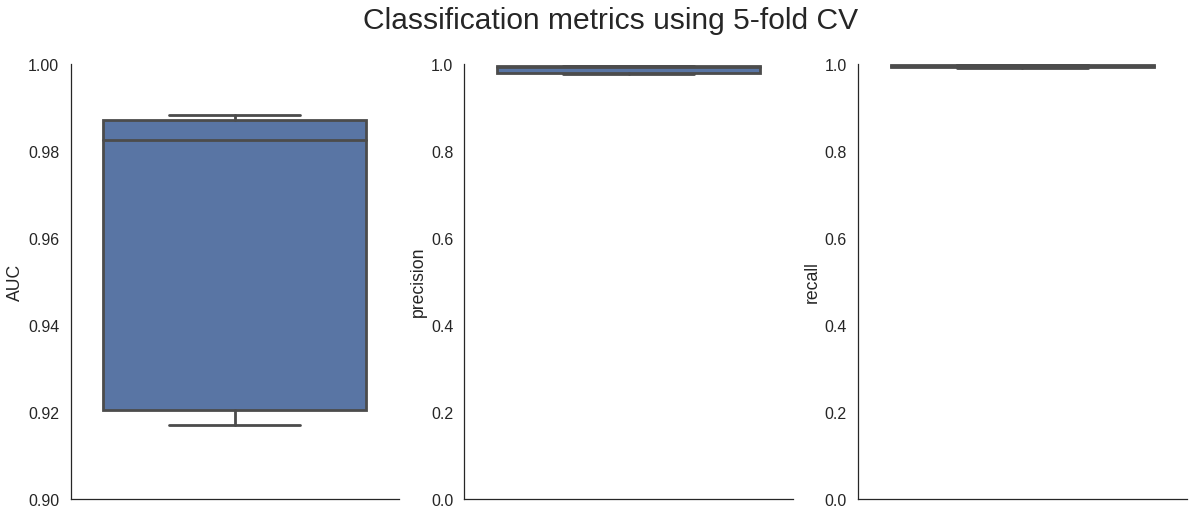

In [56]:
plt.figure(figsize=(20,8))
plt.subplot(131)
sns.boxplot(aucs, orient='v')
plt.ylim(.9,1)
plt.ylabel("AUC")

plt.subplot(132)
sns.boxplot(precision_scores, orient='v')
plt.ylim(0,1)
plt.ylabel("precision")

plt.subplot(133)
sns.boxplot(recall_scores, orient='v')
plt.ylim(0,1)
plt.ylabel("recall")
sns.despine()

plt.suptitle("Classification metrics using 5-fold CV", fontsize=30)

In [57]:
# prepare run on the real data
raw_real = io.imread('data/raw-85.tif')

# calculate the features manually
X_real = generate_features(raw_real, sigmas);

raw_real_predicted = clf.predict(X_real)
raw_real_predicted_proba = clf.predict_proba(X_real)

In [58]:
raw_real_predicted_proba.shape, raw_real_predicted.shape

((298896, 2), (298896,))

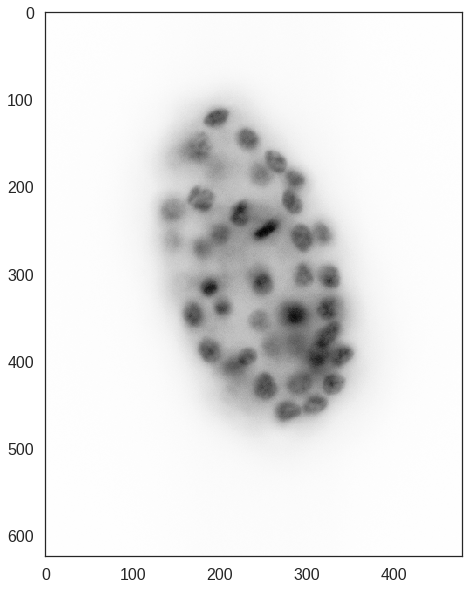

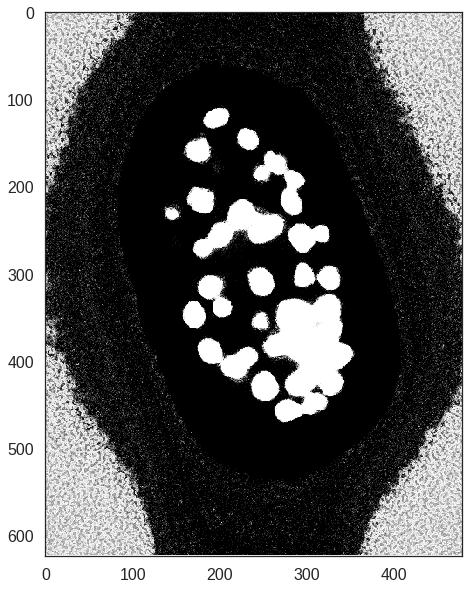

In [59]:
result = np.reshape(raw_real_predicted, raw_real.shape)
result_proba = np.reshape(raw_real_predicted_proba[:, 1], raw_real.shape)

plt.figure(figsize=(20,10))
plt.imshow(raw_real)

plt.figure(figsize=(20,10))
plt.imshow(result_proba)

# plt.figure(figsize=(20,10))
# plt.imshow(result)